# Detect Water Through S1-RTC

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from shapely import box
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from flood_finder.floodprocessor import FloodProcessor
from flood_finder.reporter import ProcessorReporter
from flood_finder.waterfinder import WaterFinder
from flood_finder.imagery import ImageFinder
from owslib.wms import WebMapService


## Define the ROI

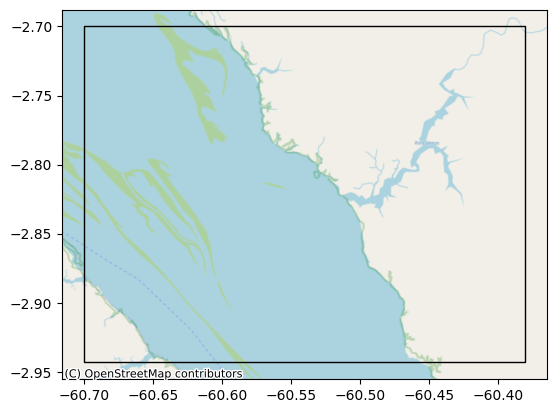

In [3]:
# Anavilhanas area
# bbox = (-61.10276214,  -2.94326633, -60.38112221,  -2.29131376)
bbox = (-60.7,  -2.94326633, -60.38112221,  -2.7)

gdf = gpd.GeoDataFrame(geometry=[box(*bbox)])
ax = gdf.plot(facecolor='none')
cx.add_basemap(ax=ax, crs='epsg:4326', source=cx.providers.OpenStreetMap.Mapnik)

## Create a `ImageFinder` instance

In [4]:
# read the subscription key
with open('../subscription.key', 'r') as file:
    subscription_key = file.read()

In [5]:
finder = ImageFinder(subscription_key=subscription_key)
s1imagery = finder.get_s1_images(
    aoi=box(*bbox),
    time_range='2023-10-11/2023-11-17',
    lee_size=None,
    group_items=True
)

In [6]:
self = s1imagery

In [7]:
s1imagery

S1Imagery Class with 1 dates

In [8]:
s1imagery.shape

In [34]:
template = s1imagery.get_raw_date(s1imagery.dates[0]).sel(band='vv')

In [38]:
import numpy as np
template.data = np.zeros(template.shape, dtype='uint8')

In [39]:
template

<xarray.DataArray 'stackstac-5e0e679aecd146a1903d6a8b45af6159' (y: 2690, x: 3549)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates: (12/28)
    band                                   <U2 'vv'
  * x                                      (x) float64 -60.7 -60.7 ... -60.38
  * y                                      (y) float64 -2.7 -2.7 ... -2.943
    sar:product_type                       <U3 'GRD'
    sar:frequency_band                     <U1 'C'
    sar:polarizations                      object {'VV', 'VH'}
    ...                                     ...
    sar:center_frequency                   float64 5.405
    s1:orbit_source                        <U6 'RESORB'
    sat:platform_international_designator  <U9 '2014-016A'
    raster:bands                           object {'nodata': -32768, 'data_ty...
    epsg                                   int64 4326
    spatial_ref                            int64 0

In [40]:
template.rio.crs

CRS.from_epsg(4326)

In [41]:
template = template.rio.reproject(dst_crs=template.rio.crs, shape=(1000, 1000))

In [16]:
s1imagery.dates

array(['2023-10-30'], dtype=object)

In [17]:
s1imagery.get_raw_date('2023-10-30')

<xarray.DataArray 'stackstac-582a20be9548ae435bea3321b867cecd' (band: 2,
                                                                y: 2690, x: 3549)>
dask.array<nanmedian, shape=(2, 2690, 3549), dtype=float32, chunksize=(1, 1595, 2103), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * band                                   (band) <U2 'vh' 'vv'
  * x                                      (x) float64 -60.7 -60.7 ... -60.38
  * y                                      (y) float64 -2.7 -2.7 ... -2.943
    sar:pixel_spacing_range                int64 10
    sar:center_frequency                   float64 5.405
    sar:resolution_range                   int64 20
    ...                                     ...
    sar:polarizations                      object {'VV', 'VH'}
    sat:platform_international_designator  <U9 '2014-016A'
    sar:looks_equivalent_number            float64 4.4
    s1:instrument_configuration_ID         <U1 '7'
    raster:bands                           object {'nodata': -32768, 'data_ty...
    epsg                                   int64 4326

In [18]:
self = s1imagery
date = '2023-10-30'

In [19]:
min_datetime = self.groups.query(f"date == '{date}'")['min_datetime'][0]
max_datetime = self.groups.query(f"date == '{date}'")['max_datetime'][0]

In [20]:
img = s1imagery.get_raw_date('2023-10-30')

In [21]:
img

<xarray.DataArray 'stackstac-e1069f851807abfcca403b02e160fc76' (band: 2,
                                                                y: 2690, x: 3549)>
dask.array<nanmedian, shape=(2, 2690, 3549), dtype=float32, chunksize=(1, 1595, 2103), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * band                                   (band) <U2 'vh' 'vv'
  * x                                      (x) float64 -60.7 -60.7 ... -60.38
  * y                                      (y) float64 -2.7 -2.7 ... -2.943
    sar:pixel_spacing_range                int64 10
    sar:center_frequency                   float64 5.405
    sar:resolution_range                   int64 20
    ...                                     ...
    sar:polarizations                      object {'VV', 'VH'}
    sat:platform_international_designator  <U9 '2014-016A'
    sar:looks_equivalent_number            float64 4.4
    s1:instrument_configuration_ID         <U1 '7'
    raster:bands                           object {'nodata': -32768, 'data_ty...
    epsg                                   int64 4326

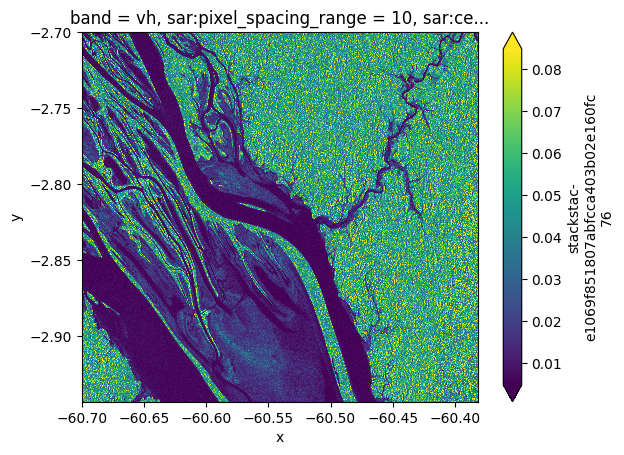

In [22]:
img.sel(band='vh').plot.imshow(robust=True)

## Create a `WaterFinder` instance

In [28]:
waterfinder = WaterFinder(
    output_path='../tmp',
    aoi=box(*bbox),
    subscription_key=subscription_key,
    time_range='2023-10-11/2023-11-17',
    print_log=True,
    group_items=True
)

waterfinder

2024-03-04 14:33:08 | tmp.WaterFinder:INFO -> Starting WaterFinder instance for tmp


2024-03-04 14:33:09 | tmp.WaterFinder:INFO -> Retrieving water recurrence
2024-03-04 14:33:11 | tmp.WaterFinder:INFO -> Retrieving dates list for the AOI


WaterFinder for place tmp
Available dates: 1
Water detected dates: 0

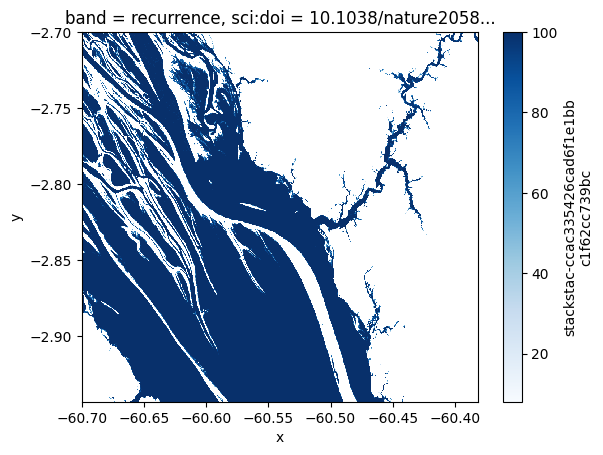

In [29]:
waterfinder.recurrence.plot(cmap='Blues')

In [46]:
waterfinder.find_water('../model/RF_Model_v2.joblib', use_gfm=False, resume=False)

  0%|          | 0/1 [00:00<?, ?it/s]

2024-03-04 15:52:48 | tmp.WaterFinder:INFO -> Seeking for water in date: 2023-10-30
2024-03-04 15:55:29 | tmp.WaterFinder:INFO -> Saving waters.nc. i=0


In [38]:
waterfinder.waters

<xarray.Dataset>
Dimensions:     (x: 1276, y: 974)
Coordinates:
  * x           (x) float64 -60.7 -60.7 -60.7 -60.7 ... -60.38 -60.38 -60.38
  * y           (y) float64 -2.7 -2.7 -2.701 -2.701 ... -2.943 -2.943 -2.943
    epsg        int64 4326
Data variables:
    2023-10-30  (y, x) int64 0 0 0 0 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0 0

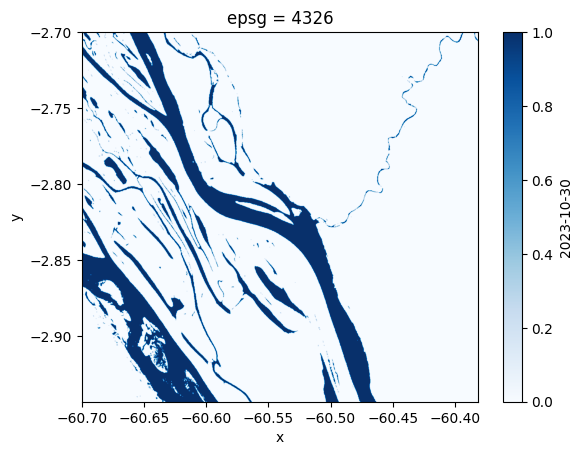

In [45]:
waterfinder.waters['2023-10-30'].plot.imshow(cmap='Blues', interpolation='bilinear')

In [47]:
waterfinder = WaterFinder(
    output_path='../tmp',
    aoi=box(*bbox),
    subscription_key=subscription_key,
    time_range='2023-10-11/2023-11-17',
    print_log=True,
    group_items=False
)
waterfinder

2024-03-04 17:24:34 | tmp.WaterFinder:INFO -> Starting WaterFinder instance for tmp
2024-03-04 17:24:35 | tmp.WaterFinder:INFO -> Retrieving water recurrence
2024-03-04 17:24:39 | tmp.WaterFinder:INFO -> Retrieving dates list for the AOI


WaterFinder for place tmp
Available dates: 6
Water detected dates: 0

In [48]:
waterfinder.find_water(use_gfm=True, resume=True)

2024-03-04 17:25:16 | tmp.WaterFinder:INFO -> Resuming from previous waters.nc file
2024-03-04 17:25:16 | tmp.WaterFinder:INFO -> Resuming from date 2023-10-30


  0%|          | 0/3 [00:00<?, ?it/s]

2024-03-04 17:26:02 | tmp.WaterFinder:INFO -> Seeking for GFM flood in date: 2023-11-05
2024-03-04 17:26:06 | tmp.WaterFinder:INFO -> Seeking for GFM flood in date: 2023-11-12
2024-03-04 17:26:08 | tmp.WaterFinder:INFO -> Seeking for GFM flood in date: 2023-11-17
2024-03-04 17:26:11 | tmp.WaterFinder:INFO -> Saving waters.nc. i=2


In [50]:
waterfinder.waters

<xarray.Dataset>
Dimensions:     (x: 1276, y: 974)
Coordinates:
  * x           (x) float64 -60.7 -60.7 -60.7 -60.7 ... -60.38 -60.38 -60.38
  * y           (y) float64 -2.7 -2.7 -2.701 -2.701 ... -2.943 -2.943 -2.943
    epsg        int64 4326
Data variables:
    2023-10-30  (y, x) uint8 0 0 0 0 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0 0
    2023-11-05  (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    2023-11-12  (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    2023-11-17  (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0

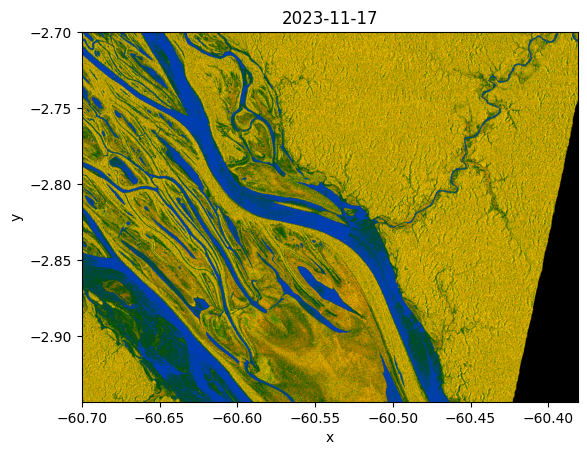

In [34]:
waterfinder.s1imagery.plot_date('2023-11-17', raw=True)

In [35]:
img = waterfinder.s1imagery.get_raw_date('2023-11-12')
img

<xarray.DataArray 'stackstac-8d464d1a23d9636fa6ac96baec5a42b5' (band: 2,
                                                                y: 2691, x: 3548)>
dask.array<nanmedian, shape=(2, 2691, 3548), dtype=float32, chunksize=(1, 2691, 3548), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * band                                   (band) <U2 'vh' 'vv'
  * x                                      (x) float64 -60.7 -60.7 ... -60.38
  * y                                      (y) float64 -2.7 -2.7 ... -2.943
    sar:looks_equivalent_number            float64 4.4
    sar:pixel_spacing_range                int64 10
    constellation                          <U10 'Sentinel-1'
    ...                                     ...
    sar:resolution_range                   int64 20
    proj:shape                             object {22153, 28809}
    sat:absolute_orbit                     int64 51182
    s1:instrument_configuration_ID         <U1 '7'
    raster:bands                           object {'nodata': -32768, 'data_ty...
    epsg                                   int64 4326

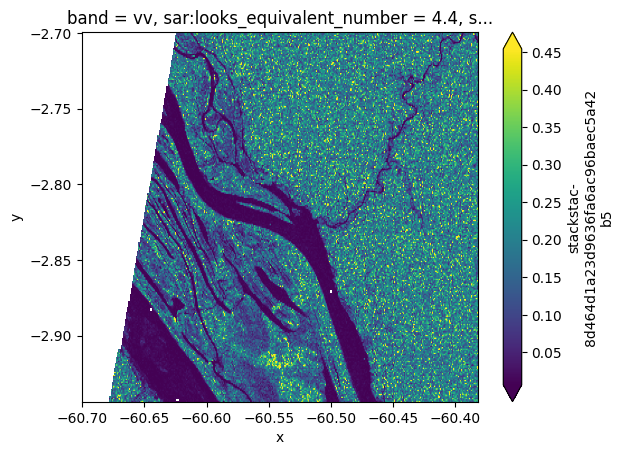

In [36]:
img.sel(band='vv', x=slice(None, None, 10), y=slice(None, None, 10)).plot.imshow(interpolation='antialiased', robust=True)

In [46]:
waterfinder.s1imagery.df

,item,datetime,dt,delta,group,date
S1A_IW_GRDH_1SDV_20231012T094738_20231012T094803_050730_061CE6_rtc,<Item id=S1A_IW_GRDH_1SDV_20231012T094738_2023...,2023-10-12 09:47:51.426041+00:00,NaT,False,5,2023-10-12
S1A_IW_GRDH_1SDV_20231012T094803_20231012T094828_050730_061CE6_rtc,<Item id=S1A_IW_GRDH_1SDV_20231012T094803_2023...,2023-10-12 09:48:16.425965+00:00,0 days 00:00:24.999924,False,5,2023-10-12
S1A_IW_GRDH_1SDV_20231019T093941_20231019T094006_050832_062070_rtc,<Item id=S1A_IW_GRDH_1SDV_20231019T093941_2023...,2023-10-19 09:39:53.883505+00:00,6 days 23:51:37.457540,True,4,2023-10-19
S1A_IW_GRDH_1SDV_20231024T094739_20231024T094804_050905_0622DD_rtc,<Item id=S1A_IW_GRDH_1SDV_20231024T094739_2023...,2023-10-24 09:47:51.966435+00:00,5 days 00:07:58.082930,True,3,2023-10-24
S1A_IW_GRDH_1SDV_20231024T094804_20231024T094829_050905_0622DD_rtc,<Item id=S1A_IW_GRDH_1SDV_20231024T094804_2023...,2023-10-24 09:48:16.966256+00:00,0 days 00:00:24.999821,False,3,2023-10-24
S1A_IW_GRDH_1SDV_20231105T094739_20231105T094804_051080_0628DA_rtc,<Item id=S1A_IW_GRDH_1SDV_20231105T094739_2023...,2023-11-05 09:47:51.632307+00:00,11 days 23:59:34.666051,True,2,2023-11-05
S1A_IW_GRDH_1SDV_20231105T094804_20231105T094829_051080_0628DA_rtc,<Item id=S1A_IW_GRDH_1SDV_20231105T094804_2023...,2023-11-05 09:48:16.632067+00:00,0 days 00:00:24.999760,False,2,2023-11-05
S1A_IW_GRDH_1SDV_20231112T093940_20231112T094005_051182_062C71_rtc,<Item id=S1A_IW_GRDH_1SDV_20231112T093940_2023...,2023-11-12 09:39:53.381144+00:00,6 days 23:51:36.749077,True,1,2023-11-12
S1A_IW_GRDH_1SDV_20231117T094738_20231117T094803_051255_062EE9_rtc,<Item id=S1A_IW_GRDH_1SDV_20231117T094738_2023...,2023-11-17 09:47:51.444706+00:00,5 days 00:07:58.063562,True,0,2023-11-17
S1A_IW_GRDH_1SDV_20231117T094803_20231117T094828_051255_062EE9_rtc,<Item id=S1A_IW_GRDH_1SDV_20231117T094803_2023...,2023-11-17 09:48:16.444494+00:00,0 days 00:00:24.999788,False,0,2023-11-17


In [47]:
from pandas import Timedelta
from flood_finder.imagery import S1Imagery

In [49]:
S1Imagery.create_grouped_df(
    items=waterfinder.s1imagery.items,
    time_delta=Timedelta('7days')
)

,item,datetime,dt,delta,group,date
S1A_IW_GRDH_1SDV_20231012T094738_20231012T094803_050730_061CE6_rtc,<Item id=S1A_IW_GRDH_1SDV_20231012T094738_2023...,2023-10-12 09:47:51.426041+00:00,NaT,False,1,2023-10-18
S1A_IW_GRDH_1SDV_20231012T094803_20231012T094828_050730_061CE6_rtc,<Item id=S1A_IW_GRDH_1SDV_20231012T094803_2023...,2023-10-12 09:48:16.425965+00:00,0 days 00:00:24.999924,False,1,2023-10-18
S1A_IW_GRDH_1SDV_20231019T093941_20231019T094006_050832_062070_rtc,<Item id=S1A_IW_GRDH_1SDV_20231019T093941_2023...,2023-10-19 09:39:53.883505+00:00,6 days 23:51:37.457540,False,1,2023-10-18
S1A_IW_GRDH_1SDV_20231024T094739_20231024T094804_050905_0622DD_rtc,<Item id=S1A_IW_GRDH_1SDV_20231024T094739_2023...,2023-10-24 09:47:51.966435+00:00,5 days 00:07:58.082930,False,1,2023-10-18
S1A_IW_GRDH_1SDV_20231024T094804_20231024T094829_050905_0622DD_rtc,<Item id=S1A_IW_GRDH_1SDV_20231024T094804_2023...,2023-10-24 09:48:16.966256+00:00,0 days 00:00:24.999821,False,1,2023-10-18
S1A_IW_GRDH_1SDV_20231105T094739_20231105T094804_051080_0628DA_rtc,<Item id=S1A_IW_GRDH_1SDV_20231105T094739_2023...,2023-11-05 09:47:51.632307+00:00,11 days 23:59:34.666051,True,0,2023-11-11
S1A_IW_GRDH_1SDV_20231105T094804_20231105T094829_051080_0628DA_rtc,<Item id=S1A_IW_GRDH_1SDV_20231105T094804_2023...,2023-11-05 09:48:16.632067+00:00,0 days 00:00:24.999760,False,0,2023-11-11
S1A_IW_GRDH_1SDV_20231112T093940_20231112T094005_051182_062C71_rtc,<Item id=S1A_IW_GRDH_1SDV_20231112T093940_2023...,2023-11-12 09:39:53.381144+00:00,6 days 23:51:36.749077,False,0,2023-11-11
S1A_IW_GRDH_1SDV_20231117T094738_20231117T094803_051255_062EE9_rtc,<Item id=S1A_IW_GRDH_1SDV_20231117T094738_2023...,2023-11-17 09:47:51.444706+00:00,5 days 00:07:58.063562,False,0,2023-11-11
S1A_IW_GRDH_1SDV_20231117T094803_20231117T094828_051255_062EE9_rtc,<Item id=S1A_IW_GRDH_1SDV_20231117T094803_2023...,2023-11-17 09:48:16.444494+00:00,0 days 00:00:24.999788,False,0,2023-11-11


In [105]:
import pandas as pd
items = waterfinder.s1imagery.items
df = pd.DataFrame(
    {item.id: {"item": item, "datetime": item.datetime} for item in items}
).T

In [110]:
df['min_datetime'] = df['datetime'].min()
df['max_datetime'] = df['datetime'].max()
df['mean_datetime'] = df['datetime'].mean()

In [94]:
time_delta = Timedelta('1days')

In [97]:
len(df)

10

In [98]:
for idx, row in df.iterrows():
    start_date = row['datetime'] - time_delta
    end_date = row['datetime'] + time_delta

    subframe = df[(df['datetime']>=start_date) & (df['datetime']<=end_date)]

    df.loc[idx, 'min_datetime'] = subframe['datetime'].min()
    df.loc[idx, 'max_datetime'] = subframe['datetime'].max()
    df.loc[idx, 'mean_datetime'] = subframe['datetime'].mean()



In [108]:
df

,item,datetime,min_datetime,max_datetime
S1A_IW_GRDH_1SDV_20231117T094803_20231117T094828_051255_062EE9_rtc,<Item id=S1A_IW_GRDH_1SDV_20231117T094803_2023...,2023-11-17 09:48:16.444494+00:00,2023-10-12 09:47:51.426041+00:00,2023-11-17 09:48:16.444494+00:00
S1A_IW_GRDH_1SDV_20231117T094738_20231117T094803_051255_062EE9_rtc,<Item id=S1A_IW_GRDH_1SDV_20231117T094738_2023...,2023-11-17 09:47:51.444706+00:00,2023-10-12 09:47:51.426041+00:00,2023-11-17 09:48:16.444494+00:00
S1A_IW_GRDH_1SDV_20231112T093940_20231112T094005_051182_062C71_rtc,<Item id=S1A_IW_GRDH_1SDV_20231112T093940_2023...,2023-11-12 09:39:53.381144+00:00,2023-10-12 09:47:51.426041+00:00,2023-11-17 09:48:16.444494+00:00
S1A_IW_GRDH_1SDV_20231105T094804_20231105T094829_051080_0628DA_rtc,<Item id=S1A_IW_GRDH_1SDV_20231105T094804_2023...,2023-11-05 09:48:16.632067+00:00,2023-10-12 09:47:51.426041+00:00,2023-11-17 09:48:16.444494+00:00
S1A_IW_GRDH_1SDV_20231105T094739_20231105T094804_051080_0628DA_rtc,<Item id=S1A_IW_GRDH_1SDV_20231105T094739_2023...,2023-11-05 09:47:51.632307+00:00,2023-10-12 09:47:51.426041+00:00,2023-11-17 09:48:16.444494+00:00
S1A_IW_GRDH_1SDV_20231024T094804_20231024T094829_050905_0622DD_rtc,<Item id=S1A_IW_GRDH_1SDV_20231024T094804_2023...,2023-10-24 09:48:16.966256+00:00,2023-10-12 09:47:51.426041+00:00,2023-11-17 09:48:16.444494+00:00
S1A_IW_GRDH_1SDV_20231024T094739_20231024T094804_050905_0622DD_rtc,<Item id=S1A_IW_GRDH_1SDV_20231024T094739_2023...,2023-10-24 09:47:51.966435+00:00,2023-10-12 09:47:51.426041+00:00,2023-11-17 09:48:16.444494+00:00
S1A_IW_GRDH_1SDV_20231019T093941_20231019T094006_050832_062070_rtc,<Item id=S1A_IW_GRDH_1SDV_20231019T093941_2023...,2023-10-19 09:39:53.883505+00:00,2023-10-12 09:47:51.426041+00:00,2023-11-17 09:48:16.444494+00:00
S1A_IW_GRDH_1SDV_20231012T094803_20231012T094828_050730_061CE6_rtc,<Item id=S1A_IW_GRDH_1SDV_20231012T094803_2023...,2023-10-12 09:48:16.425965+00:00,2023-10-12 09:47:51.426041+00:00,2023-11-17 09:48:16.444494+00:00
S1A_IW_GRDH_1SDV_20231012T094738_20231012T094803_050730_061CE6_rtc,<Item id=S1A_IW_GRDH_1SDV_20231012T094738_2023...,2023-10-12 09:47:51.426041+00:00,2023-10-12 09:47:51.426041+00:00,2023-11-17 09:48:16.444494+00:00


In [121]:
df.groupby('mean_datetime').count()

,item,datetime,min_datetime,max_datetime
mean_datetime,,,,
2023-10-30 14:34:26.020292096+00:00,10,10,10,10


In [119]:
groups = df.groupby('mean_datetime')[['min_datetime', 'max_datetime']].mean()

In [120]:
groups

,min_datetime,max_datetime
mean_datetime,,
2023-10-30 14:34:26.020292096+00:00,2023-10-12 09:47:51.426041088+00:00,2023-11-17 09:48:16.444494080+00:00


In [122]:
counter = df.groupby('mean_datetime')['item'].count()
counter

mean_datetime
2023-10-30 14:34:26.020292096+00:00    10
Name: item, dtype: int64

In [123]:
groups['count'] = counter

In [124]:
groups

,min_datetime,max_datetime,count
mean_datetime,,,
2023-10-30 14:34:26.020292096+00:00,2023-10-12 09:47:51.426041088+00:00,2023-11-17 09:48:16.444494080+00:00,10


In [102]:
groups['date'] = groups.index.strftime("%Y-%m-%d")
# groups['min_date'] = groups['min_datetime'].dt.strftime("%Y-%m-%d")
# groups['max_date'] = groups['max_datetime'].dt.strftime("%Y-%m-%d")


In [103]:
groups

,min_datetime,max_datetime,date
mean_datetime,,,
2023-10-12 09:48:03.926003200+00:00,2023-10-12 09:47:51.426041088+00:00,2023-10-12 09:48:16.425965056+00:00,2023-10-12
2023-10-19 09:39:53.883504896+00:00,2023-10-19 09:39:53.883504896+00:00,2023-10-19 09:39:53.883504896+00:00,2023-10-19
2023-10-24 09:48:04.466345472+00:00,2023-10-24 09:47:51.966435072+00:00,2023-10-24 09:48:16.966256128+00:00,2023-10-24
2023-11-05 09:48:04.132187136+00:00,2023-11-05 09:47:51.632306944+00:00,2023-11-05 09:48:16.632067072+00:00,2023-11-05
2023-11-12 09:39:53.381144064+00:00,2023-11-12 09:39:53.381144064+00:00,2023-11-12 09:39:53.381144064+00:00,2023-11-12
2023-11-17 09:48:03.944600064+00:00,2023-11-17 09:47:51.444706048+00:00,2023-11-17 09:48:16.444494080+00:00,2023-11-17


In [93]:
groups

,min_datetime,max_datetime,date
mean_datetime,,,
2023-10-14 17:45:20.578503680+00:00,2023-10-12 09:47:51.426041088+00:00,2023-10-19 09:39:53.883504896+00:00,2023-10-14
2023-10-18 14:34:26.133640192+00:00,2023-10-12 09:47:51.426041088+00:00,2023-10-24 09:48:16.966256128+00:00,2023-10-18
2023-10-22 17:45:20.938731776+00:00,2023-10-19 09:39:53.883504896+00:00,2023-10-24 09:48:16.966256128+00:00,2023-10-22
2023-11-07 17:45:20.548505856+00:00,2023-11-05 09:47:51.632306944+00:00,2023-11-12 09:39:53.381144064+00:00,2023-11-07
2023-11-11 14:34:25.906943488+00:00,2023-11-05 09:47:51.632306944+00:00,2023-11-17 09:48:16.444494080+00:00,2023-11-11
2023-11-15 17:45:20.423447808+00:00,2023-11-12 09:39:53.381144064+00:00,2023-11-17 09:48:16.444494080+00:00,2023-11-15


In [80]:
df.groupby(by=['min_datetime', 'max_datetime'])['datetime'].mean()

min_datetime                      max_datetime                    
2023-10-12 09:47:51.426041+00:00  2023-10-19 09:39:53.883505+00:00   2023-10-12 09:48:03.926003200+00:00
                                  2023-10-24 09:48:16.966256+00:00   2023-10-19 09:39:53.883504896+00:00
2023-10-19 09:39:53.883505+00:00  2023-10-24 09:48:16.966256+00:00   2023-10-24 09:48:04.466345472+00:00
2023-11-05 09:47:51.632307+00:00  2023-11-12 09:39:53.381144+00:00   2023-11-05 09:48:04.132187136+00:00
                                  2023-11-17 09:48:16.444494+00:00   2023-11-12 09:39:53.381144064+00:00
2023-11-12 09:39:53.381144+00:00  2023-11-17 09:48:16.444494+00:00   2023-11-17 09:48:03.944600064+00:00
Name: datetime, dtype: datetime64[ns, tzutc()]

In [74]:
df2 = df.set_index(['min_datetime', 'max_datetime'])
df2

item  \
min_datetime                     max_datetime                                                                          
2023-11-12 09:39:53.381144+00:00 2023-11-17 09:48:16.444494+00:00  <Item id=S1A_IW_GRDH_1SDV_20231117T094803_2023...   
                                 2023-11-17 09:48:16.444494+00:00  <Item id=S1A_IW_GRDH_1SDV_20231117T094738_2023...   
2023-11-05 09:47:51.632307+00:00 2023-11-17 09:48:16.444494+00:00  <Item id=S1A_IW_GRDH_1SDV_20231112T093940_2023...   
                                 2023-11-12 09:39:53.381144+00:00  <Item id=S1A_IW_GRDH_1SDV_20231105T094804_2023...   
                                 2023-11-12 09:39:53.381144+00:00  <Item id=S1A_IW_GRDH_1SDV_20231105T094739_2023...   
2023-10-19 09:39:53.883505+00:00 2023-10-24 09:48:16.966256+00:00  <Item id=S1A_IW_GRDH_1SDV_20231024T094804_2023...   
                                 2023-10-24 09:48:16.966256+00:00  <Item id=S1A_IW_GRDH_1SDV_20231024T094739_2023...   
2023-10-12 09:47:51.426041+00:00 2023-10-24 09:48:16.966256+00:00  <Item id=S1A_IW_GRDH_1SDV_20231019T093941_2023...   
                                 2023-10-19 09:39:53.883505+00:00  <Item id=S1A_IW_GRDH_1SDV_20231012T094803_2023...   
                                 2023-10-19 09:39:53.883505+00:00  <Item id=S1A_IW_GRDH_1SDV_20231012T094738_2023...   

                                                                                          datetime  
min_datetime                     max_datetime                                                       
2023-11-12 09:39:53.381144+00:00 2023-11-17 09:48:16.444494+00:00 2023-11-17 09:48:16.444494+00:00  
                                 2023-11-17 09:48:16.444494+00:00 2023-11-17 09:47:51.444706+00:00  
2023-11-05 09:47:51.632307+00:00 2023-11-17 09:48:16.444494+00:00 2023-11-12 09:39:53.381144+00:00  
                                 2023-11-12 09:39:53.381144+00:00 2023-11-05 09:48:16.632067+00:00  
                                 2023-11-12 09:39:53.381144+00:00 2023-11-05 09:47:51.632307+00:00  
2023-10-19 09:39:53.883505+00:00 2023-10-24 09:48:16.966256+00:00 2023-10-24 09:48:16.966256+00:00  
                                 2023-10-24 09:48:16.966256+00:00 2023-10-24 09:47:51.966435+00:00  
2023-10-12 09:47:51.426041+00:00 2023-10-24 09:48:16.966256+00:00 2023-10-19 09:39:53.883505+00:00  
                                 2023-10-19 09:39:53.883505+00:00 2023-10-12 09:48:16.425965+00:00  
                                 2023-10-19 09:39:53.883505+00:00 2023-10-12 09:47:51.426041+00:00

In [78]:
df2.join(df.groupby(by=['min_datetime', 'max_datetime'])['datetime'].mean(), lsuffix='_left', rsuffix='_right')

item  \
min_datetime                     max_datetime                                                                          
2023-10-12 09:47:51.426041+00:00 2023-10-19 09:39:53.883505+00:00  <Item id=S1A_IW_GRDH_1SDV_20231012T094803_2023...   
                                 2023-10-19 09:39:53.883505+00:00  <Item id=S1A_IW_GRDH_1SDV_20231012T094738_2023...   
                                 2023-10-24 09:48:16.966256+00:00  <Item id=S1A_IW_GRDH_1SDV_20231019T093941_2023...   
2023-10-19 09:39:53.883505+00:00 2023-10-24 09:48:16.966256+00:00  <Item id=S1A_IW_GRDH_1SDV_20231024T094804_2023...   
                                 2023-10-24 09:48:16.966256+00:00  <Item id=S1A_IW_GRDH_1SDV_20231024T094739_2023...   
2023-11-05 09:47:51.632307+00:00 2023-11-12 09:39:53.381144+00:00  <Item id=S1A_IW_GRDH_1SDV_20231105T094804_2023...   
                                 2023-11-12 09:39:53.381144+00:00  <Item id=S1A_IW_GRDH_1SDV_20231105T094739_2023...   
                                 2023-11-17 09:48:16.444494+00:00  <Item id=S1A_IW_GRDH_1SDV_20231112T093940_2023...   
2023-11-12 09:39:53.381144+00:00 2023-11-17 09:48:16.444494+00:00  <Item id=S1A_IW_GRDH_1SDV_20231117T094803_2023...   
                                 2023-11-17 09:48:16.444494+00:00  <Item id=S1A_IW_GRDH_1SDV_20231117T094738_2023...   

                                                                                     datetime_left  \
min_datetime                     max_datetime                                                        
2023-10-12 09:47:51.426041+00:00 2023-10-19 09:39:53.883505+00:00 2023-10-12 09:48:16.425965+00:00   
                                 2023-10-19 09:39:53.883505+00:00 2023-10-12 09:47:51.426041+00:00   
                                 2023-10-24 09:48:16.966256+00:00 2023-10-19 09:39:53.883505+00:00   
2023-10-19 09:39:53.883505+00:00 2023-10-24 09:48:16.966256+00:00 2023-10-24 09:48:16.966256+00:00   
                                 2023-10-24 09:48:16.966256+00:00 2023-10-24 09:47:51.966435+00:00   
2023-11-05 09:47:51.632307+00:00 2023-11-12 09:39:53.381144+00:00 2023-11-05 09:48:16.632067+00:00   
                                 2023-11-12 09:39:53.381144+00:00 2023-11-05 09:47:51.632307+00:00   
                                 2023-11-17 09:48:16.444494+00:00 2023-11-12 09:39:53.381144+00:00   
2023-11-12 09:39:53.381144+00:00 2023-11-17 09:48:16.444494+00:00 2023-11-17 09:48:16.444494+00:00   
                                 2023-11-17 09:48:16.444494+00:00 2023-11-17 09:47:51.444706+00:00   

                                                                                       datetime_right  
min_datetime                     max_datetime                                                          
2023-10-12 09:47:51.426041+00:00 2023-10-19 09:39:53.883505+00:00 2023-10-12 09:48:03.926003200+00:00  
                                 2023-10-19 09:39:53.883505+00:00 2023-10-12 09:48:03.926003200+00:00  
                                 2023-10-24 09:48:16.966256+00:00 2023-10-19 09:39:53.883504896+00:00  
2023-10-19 09:39:53.883505+00:00 2023-10-24 09:48:16.966256+00:00 2023-10-24 09:48:04.466345472+00:00  
                                 2023-10-24 09:48:16.966256+00:00 2023-10-24 09:48:04.466345472+00:00  
2023-11-05 09:47:51.632307+00:00 2023-11-12 09:39:53.381144+00:00 2023-11-05 09:48:04.132187136+00:00  
                                 2023-11-12 09:39:53.381144+00:00 2023-11-05 09:48:04.132187136+00:00  
                                 2023-11-17 09:48:16.444494+00:00 2023-11-12 09:39:53.381144064+00:00  
2023-11-12 09:39:53.381144+00:00 2023-11-17 09:48:16.444494+00:00 2023-11-17 09:48:03.944600064+00:00  
                                 2023-11-17 09:48:16.444494+00:00 2023-11-17 09:48:03.944600064+00:00

In [62]:
df['datetime'] > (df['datetime'][0] - time_delta)

S1A_IW_GRDH_1SDV_20231117T094803_20231117T094828_051255_062EE9_rtc     True
S1A_IW_GRDH_1SDV_20231117T094738_20231117T094803_051255_062EE9_rtc     True
S1A_IW_GRDH_1SDV_20231112T093940_20231112T094005_051182_062C71_rtc     True
S1A_IW_GRDH_1SDV_20231105T094804_20231105T094829_051080_0628DA_rtc    False
S1A_IW_GRDH_1SDV_20231105T094739_20231105T094804_051080_0628DA_rtc    False
S1A_IW_GRDH_1SDV_20231024T094804_20231024T094829_050905_0622DD_rtc    False
S1A_IW_GRDH_1SDV_20231024T094739_20231024T094804_050905_0622DD_rtc    False
S1A_IW_GRDH_1SDV_20231019T093941_20231019T094006_050832_062070_rtc    False
S1A_IW_GRDH_1SDV_20231012T094803_20231012T094828_050730_061CE6_rtc    False
S1A_IW_GRDH_1SDV_20231012T094738_20231012T094803_050730_061CE6_rtc    False
Name: datetime, dtype: bool

In [14]:
waterfinder.find_water(
    model_path='../model/RF_Model_v2.joblib',
    use_gfm=False
)

NotImplementedError: Find Water through Random Forests not implemented

## Use the GFM webservice

In [9]:
wms_t = WebMapService(WaterFinder.GFM_URL)

In [12]:
layers = list(wms_t.contents)

In [13]:
layers

['advisory_flags_group_layer',
 'affected_landcover_group_layer',
 'affected_population_group_layer',
 'exclusion_mask_group_layer',
 'observed_flood_extent_group_layer',
 'observed_water_extent_group_layer',
 'reference_water_mask_group_layer',
 'uncertainty_values_group_layer',
 'advisory_flags',
 'advisory_flags_footprint_geom',
 'affected_landcover',
 'affected_landcover_footprint',
 'affected_population',
 'affected_population_footprint',
 'exclusion_mask',
 'exclusion_mask_footprint',
 'observed_flood_extent',
 'observed_flood_extent_footprint',
 'observed_water_extent',
 'observed_water_extent_footprint',
 'reference_water_mask',
 'reference_water_mask_footprint',
 'sentinel_1_footprint',
 'sentinel_1_footprint_old',
 'sentinel_1_metadata',
 'sentinel_1_schedule',
 'uncertainty_values',
 'uncertainty_values_footprint']

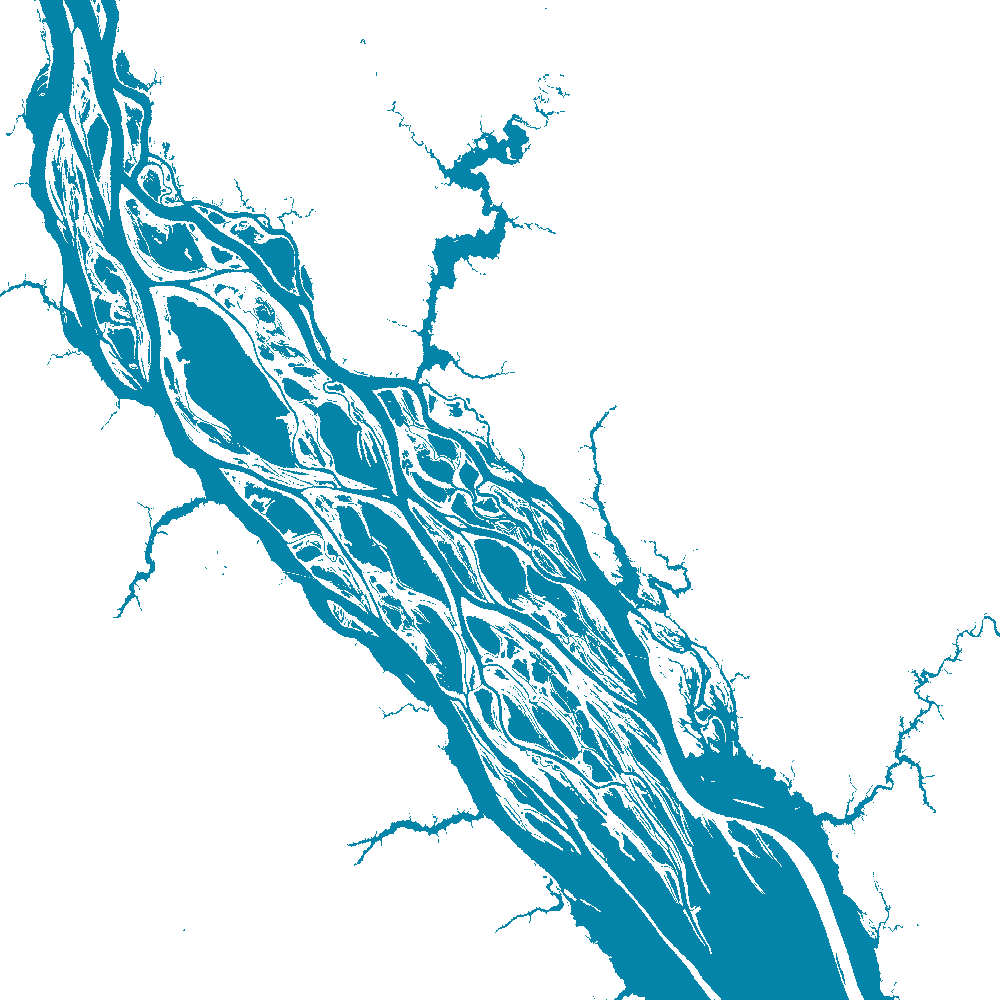

In [25]:
img = WaterFinder.get_wms_img(
    time_range='2023-10-1/2023-12-30',
    layer='observed_water_extent',
    bbox=bbox,
    size=(1000, 1000),
    wms_t = wms_t
)

img

![](<attachment:WhatsApp Image 2024-03-01 at 10.15.30_e3e784e1.jpg>)

![WhatsApp Image 2024-03-01 at 10.15.30_e3e784e1.jpg](<attachment:WhatsApp Image 2024-03-01 at 10.15.30_e3e784e1.jpg>)
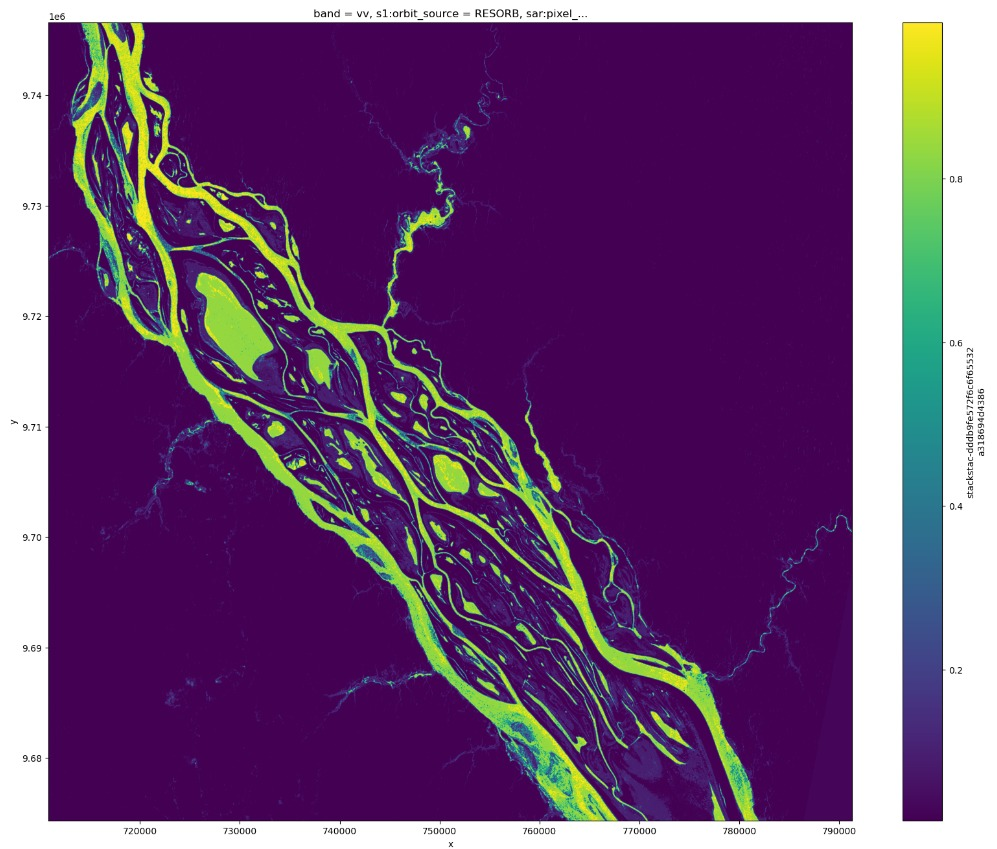

Comparing the GFM Water Extent with the very dry reality we can be certain GFM is not detecting water, just floods. THe algorithms look for standard deviations from the mean signal, and the observed water extent is the baseline water mask for that month. This is not a layer that should be used as water detection. 